# Usable Artificial Intelligence - Final Project Submission
## Individual Carbon Footprint Estimation
## Surya Teja Mothukuri - smothuk@iu.edu

### About the Problem and Dataset

One of the biggest problems the world is currently experiencing is climate change, which is accelerated in large part by human activity, especially our daily lifestyle choices. Every action we take, from how we travel and use energy to what we eat and how much garbage we produce, adds to our individual carbon footprint. Even yet, the majority of people are ignorant of the true effects of their behaviors. To assist individuals understand how their actions impact the environment, it is crucial to develop technologies that can calculate and visualize individual carbon emissions. We can raise awareness, help international efforts to reduce greenhouse gas emissions, and encourage sustainable decision-making by quantifying individual carbon footprints using data and machine learning.

This open-source Carbon Emission dataset containts structured data and information about lifestyle habits related to daily consumption and activities that contribute to carbon emissions.

Types of features that are included are:
1. Demographic Data: Age, gender, region
2. Energy Consumption: Monthly electricity and natural gas usage
3. Transportation Habits: Weekly car travel distance, annual flight count
4. Diet Type: Categories like vegetarian, vegan, omnivore, etc.
5. Waste Management: Monthly waste generation in kg
6. Water Consumption: Daily water usage in liters
7. Calculated Carbon Footprint: The total CO₂ emission in kg/month, serving as the target variable

## Importing required libraries and data

In [5]:
import math
import os 
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
df = pd.read_csv('Carbon Emission.csv')

In [7]:
df.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


### Lets add some more features using our existing features and try to make the dataset more informative in order for better and detailed calcualtions

#### Note : All scores and estimations are standard and have been found from Google and other websites and are not pure random numbers

In [9]:
# Diet Emission Scores (kg CO2 per month)
diet_emission_map = {
    'vegan': 100,
    'vegetarian': 130,
    'pescatarian': 150,
    'omnivore': 250,
    'meat-heavy': 300
}

# Air Travel Mapping (estimated flights/year → monthly CO2)
air_travel_map = {
    'never': 0,
    'rarely': 1,
    'sometimes': 3,
    'frequently': 6,
    'very frequently': 12
}

# Heating Energy Source Emissions (kg CO2/kWh equivalent)
heating_map = {
    'coal': 0.35,
    'natural gas': 0.2,
    'wood': 0.1,
    'electric': 0.25,
    'renewable': 0.05
}

# Waste Bag Size volume approximation (in kg per bag)
waste_bag_size_map = {
    'small': 5,
    'medium': 10,
    'large': 15,
    'extra large': 20
}

In [10]:
df['diet_emissions'] = df['Diet'].str.lower().map(diet_emission_map)


df['flight_trips'] = df['Frequency of Traveling by Air'].str.lower().map(air_travel_map)
df['flight_emissions'] = df['flight_trips'] * (250 / 12)  # Monthly avg

df['vehicle_emissions'] = df['Vehicle Monthly Distance Km'].fillna(0) * 0.192  # kg CO2/km

df['heating_emissions'] = df['Heating Energy Source'].str.lower().map(heating_map).fillna(0.2)

# Waste emissions = size × count × 4 weeks × 1.8 kg CO2/kg
df['waste_kg_month'] = df['Waste Bag Size'].str.lower().map(waste_bag_size_map) * df['Waste Bag Weekly Count'] * 4
df['waste_emissions'] = df['waste_kg_month'] * 1.8

# Add proxy for appliance usage (e.g., energy from TV, Internet)
df['appliance_use_score'] = df['How Long TV PC Daily Hour'] + df['How Long Internet Daily Hour']

# Clothing impact (proxy for consumption)
df['clothing_emissions'] = df['How Many New Clothes Monthly'] * 10  # estimate

df['energy_efficient'] = df['Energy efficiency'].map({'Yes': 1, 'Sometimes': 0.5, 'No': 0}).fillna(0)

# Binary flag for recycling multiple types
df['recycling_score'] = df['Recycling'].apply(lambda x: len(eval(x)) if pd.notnull(x) else 0)

1. Diet Emissions - Mapping each diet type to an estimated monthly Co2 impact
2. Flight Emissions - Estimating flight trips on the basis of regularity and emissions from those air travels.
3. Vehicle Emissions - Calculates CO₂ emissions from private car usage (monthly km × emission factor)
4. Heating Emissions - Assigns an emissions factor based on heating source (coal, gas, wood, etc.).
5. Waste Emissions - Estimates total waste generated per month and its emission equivalent.
6. Appliance Use Score - Adds up daily hours spent on electronics as a proxy for electricity usage.
7. Clothing Emissions - Estimates emissions from buying new clothes (textile production has a carbon cost).
8. Energy Efficient - Numerical representation of energy efficiency practices at home.
9. Recycling Score - Counts how many categories of materials a person recycles (paper, plastic, glass, etc.)

In [12]:
df.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,...,flight_trips,flight_emissions,vehicle_emissions,heating_emissions,waste_kg_month,waste_emissions,appliance_use_score,clothing_emissions,energy_efficient,recycling_score
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,...,6,125.000000,40.320,0.35,240,432.0,8,260,0.0,1
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,...,1,20.833333,1.728,0.20,240,432.0,14,380,0.0,1
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,...,0,0.000000,474.624,0.10,20,36.0,20,470,0.5,1
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,...,1,20.833333,14.208,0.10,120,216.0,27,50,0.5,4
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,...,12,250.000000,1623.744,0.35,60,108.0,9,50,1.0,1


In [13]:
df.to_csv('new_emissions.csv')

In [14]:
data = pd.read_csv('new_emissions.csv',index_col=0)
data.head(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,...,flight_trips,flight_emissions,vehicle_emissions,heating_emissions,waste_kg_month,waste_emissions,appliance_use_score,clothing_emissions,energy_efficient,recycling_score
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,...,6,125.000000,40.320,0.35,240,432.0,8,260,0.0,1
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,...,1,20.833333,1.728,0.20,240,432.0,14,380,0.0,1
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,...,0,0.000000,474.624,0.10,20,36.0,20,470,0.5,1
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,...,1,20.833333,14.208,0.10,120,216.0,27,50,0.5,4
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,...,12,250.000000,1623.744,0.35,60,108.0,9,50,1.0,1


In [15]:
col = 'CarbonEmission'
df = df[[c for c in df.columns if c != col] + [col]]

In [16]:
df.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,...,flight_emissions,vehicle_emissions,heating_emissions,waste_kg_month,waste_emissions,appliance_use_score,clothing_emissions,energy_efficient,recycling_score,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,...,125.000000,40.320,0.35,240,432.0,8,260,0.0,1,2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,...,20.833333,1.728,0.20,240,432.0,14,380,0.0,1,1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,...,0.000000,474.624,0.10,20,36.0,20,470,0.5,1,2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,...,20.833333,14.208,0.10,120,216.0,27,50,0.5,4,1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,...,250.000000,1623.744,0.35,60,108.0,9,50,1.0,1,4743


In [17]:
df.shape

(10000, 31)

In [18]:
df.isnull().sum()

Body Type                           0
Sex                                 0
Diet                                0
How Often Shower                    0
Heating Energy Source               0
Transport                           0
Vehicle Type                     6721
Social Activity                     0
Monthly Grocery Bill                0
Frequency of Traveling by Air       0
Vehicle Monthly Distance Km         0
Waste Bag Size                      0
Waste Bag Weekly Count              0
How Long TV PC Daily Hour           0
How Many New Clothes Monthly        0
How Long Internet Daily Hour        0
Energy efficiency                   0
Recycling                           0
Cooking_With                        0
diet_emissions                      0
flight_trips                        0
flight_emissions                    0
vehicle_emissions                   0
heating_emissions                   0
waste_kg_month                      0
waste_emissions                     0
appliance_us

We observe that the column 'Vehicle Type' has 6721 missing values and is generally petrol (2.31 kg Co2/liter) or diesel (2.68 kg Co2/liter). While there is a difference between carbon emissions of both of them, it is wise to drop the column and proceed with analysis and modelling for our problem statement.

In [20]:
df.drop(columns=['Vehicle Type'], inplace=True)

In [21]:
df.isnull().sum()

Body Type                        0
Sex                              0
Diet                             0
How Often Shower                 0
Heating Energy Source            0
Transport                        0
Social Activity                  0
Monthly Grocery Bill             0
Frequency of Traveling by Air    0
Vehicle Monthly Distance Km      0
Waste Bag Size                   0
Waste Bag Weekly Count           0
How Long TV PC Daily Hour        0
How Many New Clothes Monthly     0
How Long Internet Daily Hour     0
Energy efficiency                0
Recycling                        0
Cooking_With                     0
diet_emissions                   0
flight_trips                     0
flight_emissions                 0
vehicle_emissions                0
heating_emissions                0
waste_kg_month                   0
waste_emissions                  0
appliance_use_score              0
clothing_emissions               0
energy_efficient                 0
recycling_score     

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Body Type                      10000 non-null  object 
 1   Sex                            10000 non-null  object 
 2   Diet                           10000 non-null  object 
 3   How Often Shower               10000 non-null  object 
 4   Heating Energy Source          10000 non-null  object 
 5   Transport                      10000 non-null  object 
 6   Social Activity                10000 non-null  object 
 7   Monthly Grocery Bill           10000 non-null  int64  
 8   Frequency of Traveling by Air  10000 non-null  object 
 9   Vehicle Monthly Distance Km    10000 non-null  int64  
 10  Waste Bag Size                 10000 non-null  object 
 11  Waste Bag Weekly Count         10000 non-null  int64  
 12  How Long TV PC Daily Hour      10000 non-null  

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Monthly Grocery Bill,10000.0,173.875200,72.234018,50.0,111.000000,173.000,237.000,299.000
Vehicle Monthly Distance Km,10000.0,2031.485900,2769.715597,0.0,69.000000,823.000,2516.750,9999.000
Waste Bag Weekly Count,10000.0,4.024600,1.990375,1.0,2.000000,4.000,6.000,7.000
How Long TV PC Daily Hour,10000.0,12.139200,7.106369,0.0,6.000000,12.000,18.000,24.000
How Many New Clothes Monthly,10000.0,25.109000,14.698725,0.0,13.000000,25.000,38.000,50.000
How Long Internet Daily Hour,10000.0,11.889100,7.277218,0.0,6.000000,12.000,18.000,24.000
diet_emissions,10000.0,157.521000,56.198580,100.0,130.000000,150.000,150.000,250.000
flight_trips,10000.0,4.810100,4.772349,0.0,1.000000,6.000,12.000,12.000
flight_emissions,10000.0,100.210417,99.423939,0.0,20.833333,125.000,250.000,250.000
vehicle_emissions,10000.0,390.045293,531.785395,0.0,13.248000,158.016,483.216,1919.808


In [24]:
exclude_cols = ['Recycling', 'Cooking_With']

categorical_cols = [
    col for col in df.select_dtypes(include=['object', 'category']).columns
    if col not in exclude_cols
]

for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())


Unique values in 'Body Type':
['overweight' 'obese' 'underweight' 'normal']

Unique values in 'Sex':
['female' 'male']

Unique values in 'Diet':
['pescatarian' 'vegetarian' 'omnivore' 'vegan']

Unique values in 'How Often Shower':
['daily' 'less frequently' 'more frequently' 'twice a day']

Unique values in 'Heating Energy Source':
['coal' 'natural gas' 'wood' 'electricity']

Unique values in 'Transport':
['public' 'walk/bicycle' 'private']

Unique values in 'Social Activity':
['often' 'never' 'sometimes']

Unique values in 'Frequency of Traveling by Air':
['frequently' 'rarely' 'never' 'very frequently']

Unique values in 'Waste Bag Size':
['large' 'extra large' 'small' 'medium']

Unique values in 'Energy efficiency':
['No' 'Sometimes' 'Yes']


In [25]:
for col in categorical_cols:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts())


Value counts for 'Body Type':
Body Type
underweight    2540
obese          2500
overweight     2487
normal         2473
Name: count, dtype: int64

Value counts for 'Sex':
Sex
female    5007
male      4993
Name: count, dtype: int64

Value counts for 'Diet':
Diet
pescatarian    2554
vegan          2497
omnivore       2492
vegetarian     2457
Name: count, dtype: int64

Value counts for 'How Often Shower':
How Often Shower
daily              2546
twice a day        2516
less frequently    2487
more frequently    2451
Name: count, dtype: int64

Value counts for 'Heating Energy Source':
Heating Energy Source
electricity    2552
coal           2523
wood           2463
natural gas    2462
Name: count, dtype: int64

Value counts for 'Transport':
Transport
walk/bicycle    3427
public          3294
private         3279
Name: count, dtype: int64

Value counts for 'Social Activity':
Social Activity
never        3406
often        3319
sometimes    3275
Name: count, dtype: int64

Value counts for 'F

In [26]:
categorical_columns = [
    'Diet', 'Transport', 'Heating Energy Source', 'Waste Bag Size',
    'Sex', 'Body Type', 'Frequency of Traveling by Air', 
    'Energy efficiency', 'How Often Shower', 'Social Activity'
]

anova_results = {}

for col in categorical_columns:
    try:
        groups = [group['CarbonEmission'].values for name, group in df.groupby(col)]
        if len(groups) > 1:
            f_stat, p_value = f_oneway(*groups)
            anova_results[col] = p_value
        else:
            anova_results[col] = "Not enough groups"
    except Exception as e:
        anova_results[col] = f"Error: {e}"

sorted_results = dict(sorted(anova_results.items(), key=lambda x: x[1] if isinstance(x[1], float) else 1))

print("----------------Analysis of Variance---------------")
for key, value in sorted_results.items():
    print(f"{key}: p-value = {value}")

----------------Analysis of Variance---------------
Diet: p-value = Error: name 'f_oneway' is not defined
Transport: p-value = Error: name 'f_oneway' is not defined
Heating Energy Source: p-value = Error: name 'f_oneway' is not defined
Waste Bag Size: p-value = Error: name 'f_oneway' is not defined
Sex: p-value = Error: name 'f_oneway' is not defined
Body Type: p-value = Error: name 'f_oneway' is not defined
Frequency of Traveling by Air: p-value = Error: name 'f_oneway' is not defined
Energy efficiency: p-value = Error: name 'f_oneway' is not defined
How Often Shower: p-value = Error: name 'f_oneway' is not defined
Social Activity: p-value = Error: name 'f_oneway' is not defined


In [27]:
categorical_pairs = [
    ('Transport', 'Diet'),
    ('Transport', 'Sex'),
    ('Transport', 'Frequency of Traveling by Air'),
    ('Diet', 'Sex'),
    ('Diet', 'Energy efficiency'),
    ('Diet', 'Frequency of Traveling by Air'),
    ('Sex', 'Energy efficiency'),
    ('Waste Bag Size', 'Sex'),
    ('Energy efficiency', 'Frequency of Traveling by Air'),
    ('Diet', 'Waste Bag Size')
]

chi2_results = {}

for var1, var2 in categorical_pairs:
    try:
        contingency = pd.crosstab(df[var1], df[var2])
        chi2, p, dof, expected = chi2_contingency(contingency)
        chi2_results[f"{var1} vs {var2}"] = p
    except Exception as e:
        chi2_results[f"{var1} vs {var2}"] = f"Error: {e}"

sorted_chi2 = dict(sorted(chi2_results.items(), key=lambda x: x[1] if isinstance(x[1], float) else 1))
print("----------------Chi-Square Tests for Categorical Variables---------------")
for key, value in sorted_chi2.items():
    print(f"{key}: p-value = {value:.6f}" if isinstance(value, float) else f"{key}: {value}")

----------------Chi-Square Tests for Categorical Variables---------------
Transport vs Diet: Error: name 'chi2_contingency' is not defined
Transport vs Sex: Error: name 'chi2_contingency' is not defined
Transport vs Frequency of Traveling by Air: Error: name 'chi2_contingency' is not defined
Diet vs Sex: Error: name 'chi2_contingency' is not defined
Diet vs Energy efficiency: Error: name 'chi2_contingency' is not defined
Diet vs Frequency of Traveling by Air: Error: name 'chi2_contingency' is not defined
Sex vs Energy efficiency: Error: name 'chi2_contingency' is not defined
Waste Bag Size vs Sex: Error: name 'chi2_contingency' is not defined
Energy efficiency vs Frequency of Traveling by Air: Error: name 'chi2_contingency' is not defined
Diet vs Waste Bag Size: Error: name 'chi2_contingency' is not defined


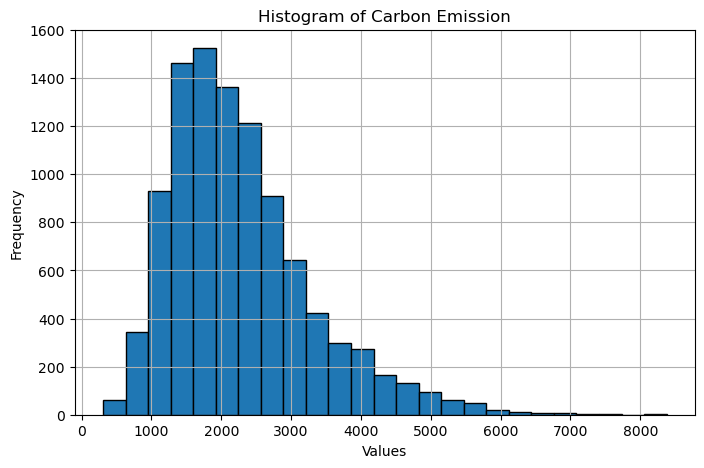

In [28]:
plt.figure(figsize=(8, 5))
df['CarbonEmission'].hist(bins=25, edgecolor='black')
plt.title('Histogram of Carbon Emission')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

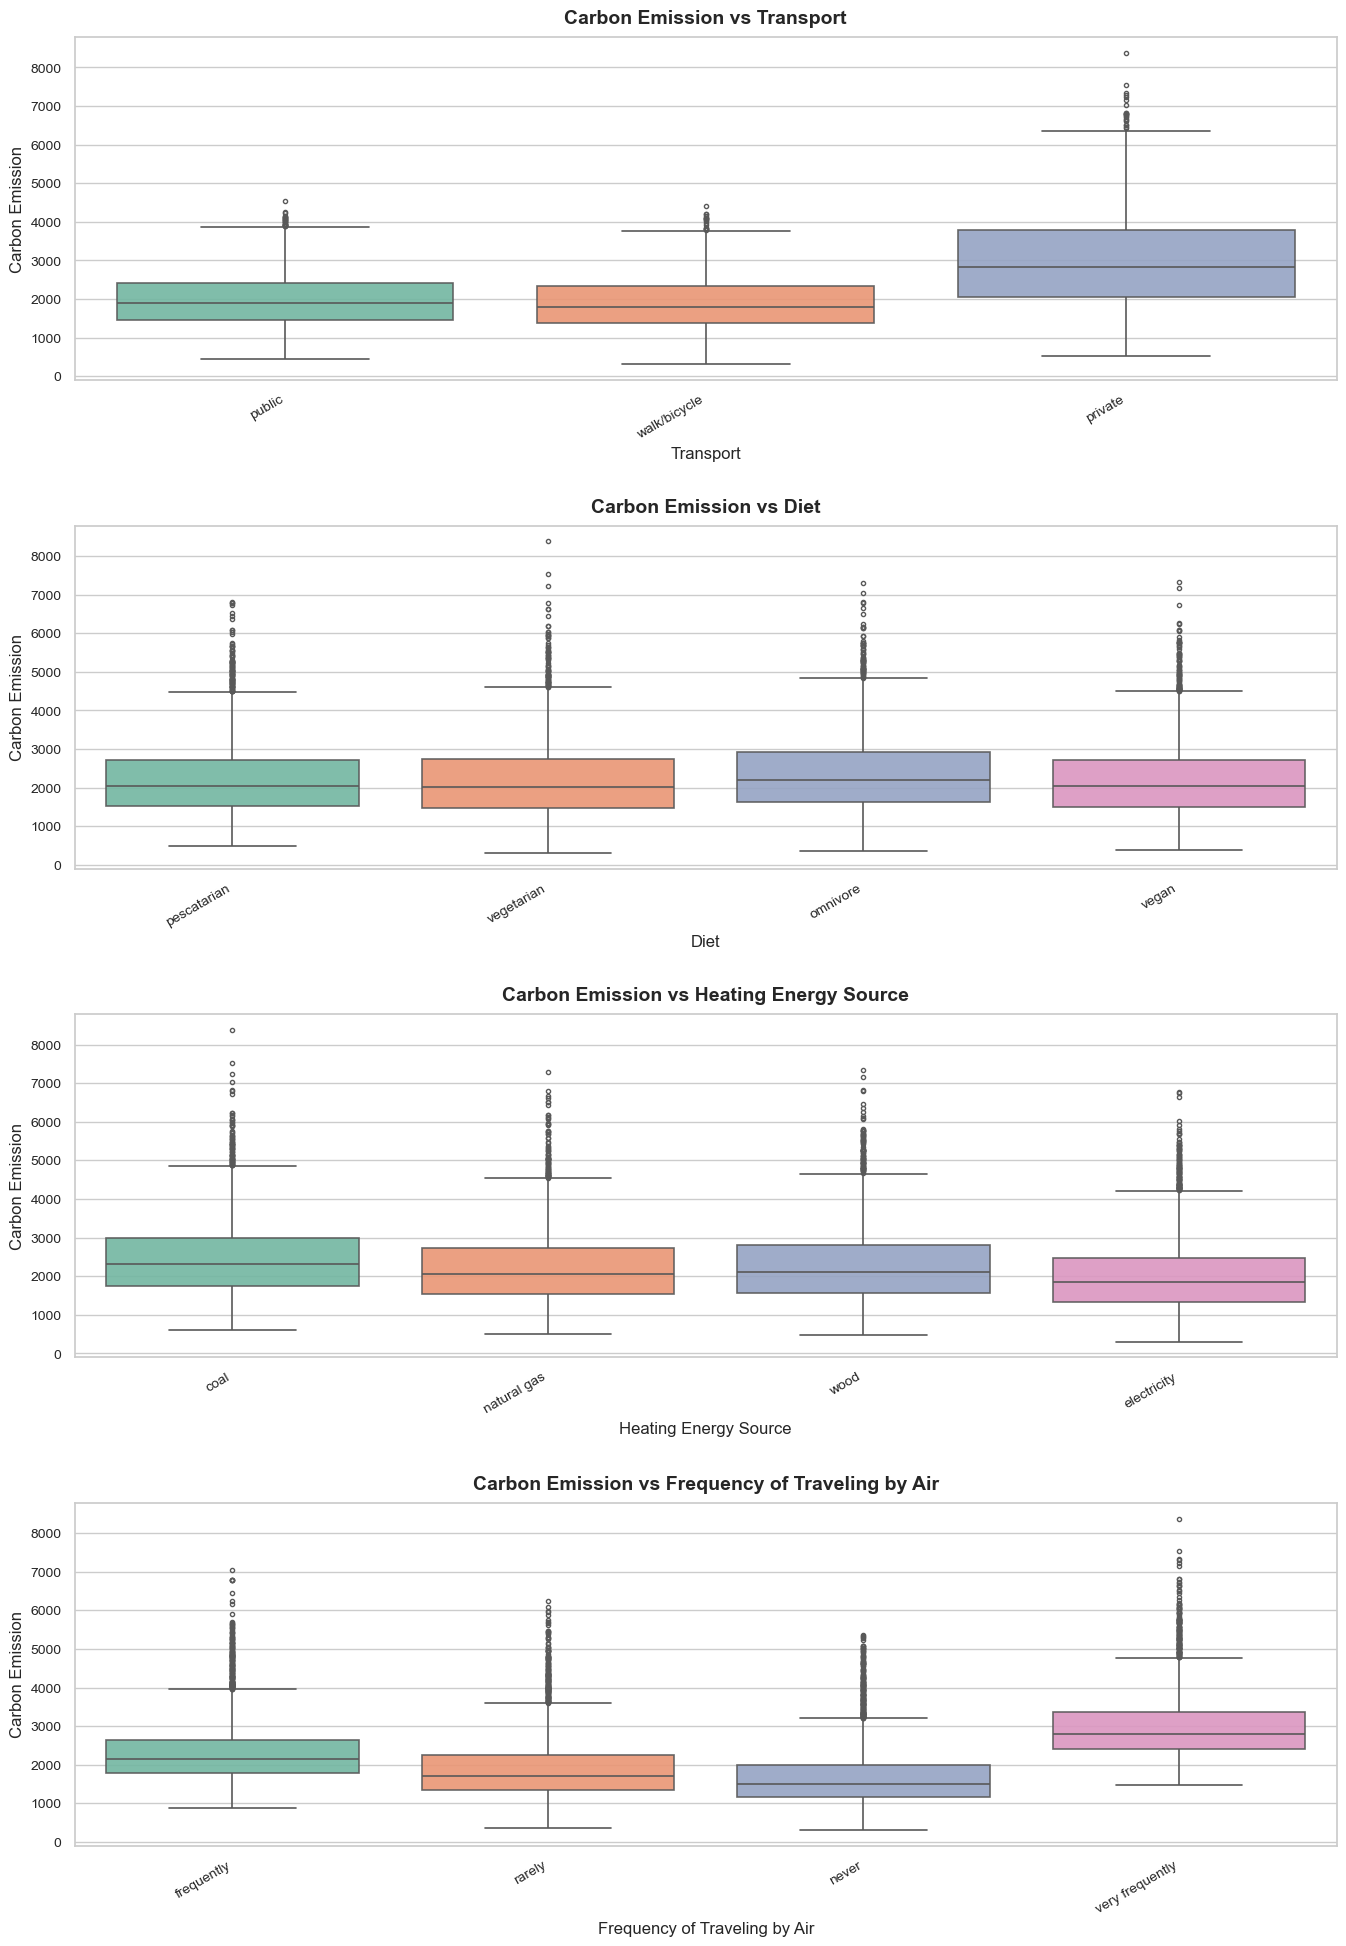

In [29]:
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(14, 20))

cat_vars = [
    'Transport',
    'Diet',
    'Heating Energy Source',
    'Frequency of Traveling by Air'
]

palette = sns.color_palette("Set2")  

for i, col in enumerate(cat_vars, 1):
    plt.subplot(len(cat_vars), 1, i)
    sns.boxplot(
        x=col,
        y='CarbonEmission',
        data=df,
        palette=palette,
        linewidth=1.2,        
        fliersize=3,
        boxprops=dict(alpha=0.9) 
    )
    
    plt.title(f'Carbon Emission vs {col}', fontsize=14, weight='bold', pad=10)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Carbon Emission", fontsize=12)
    plt.xticks(rotation=30, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout(pad=2.0)
plt.savefig("carbon_emission_boxplots_strong_color.png", dpi=300)
plt.show()

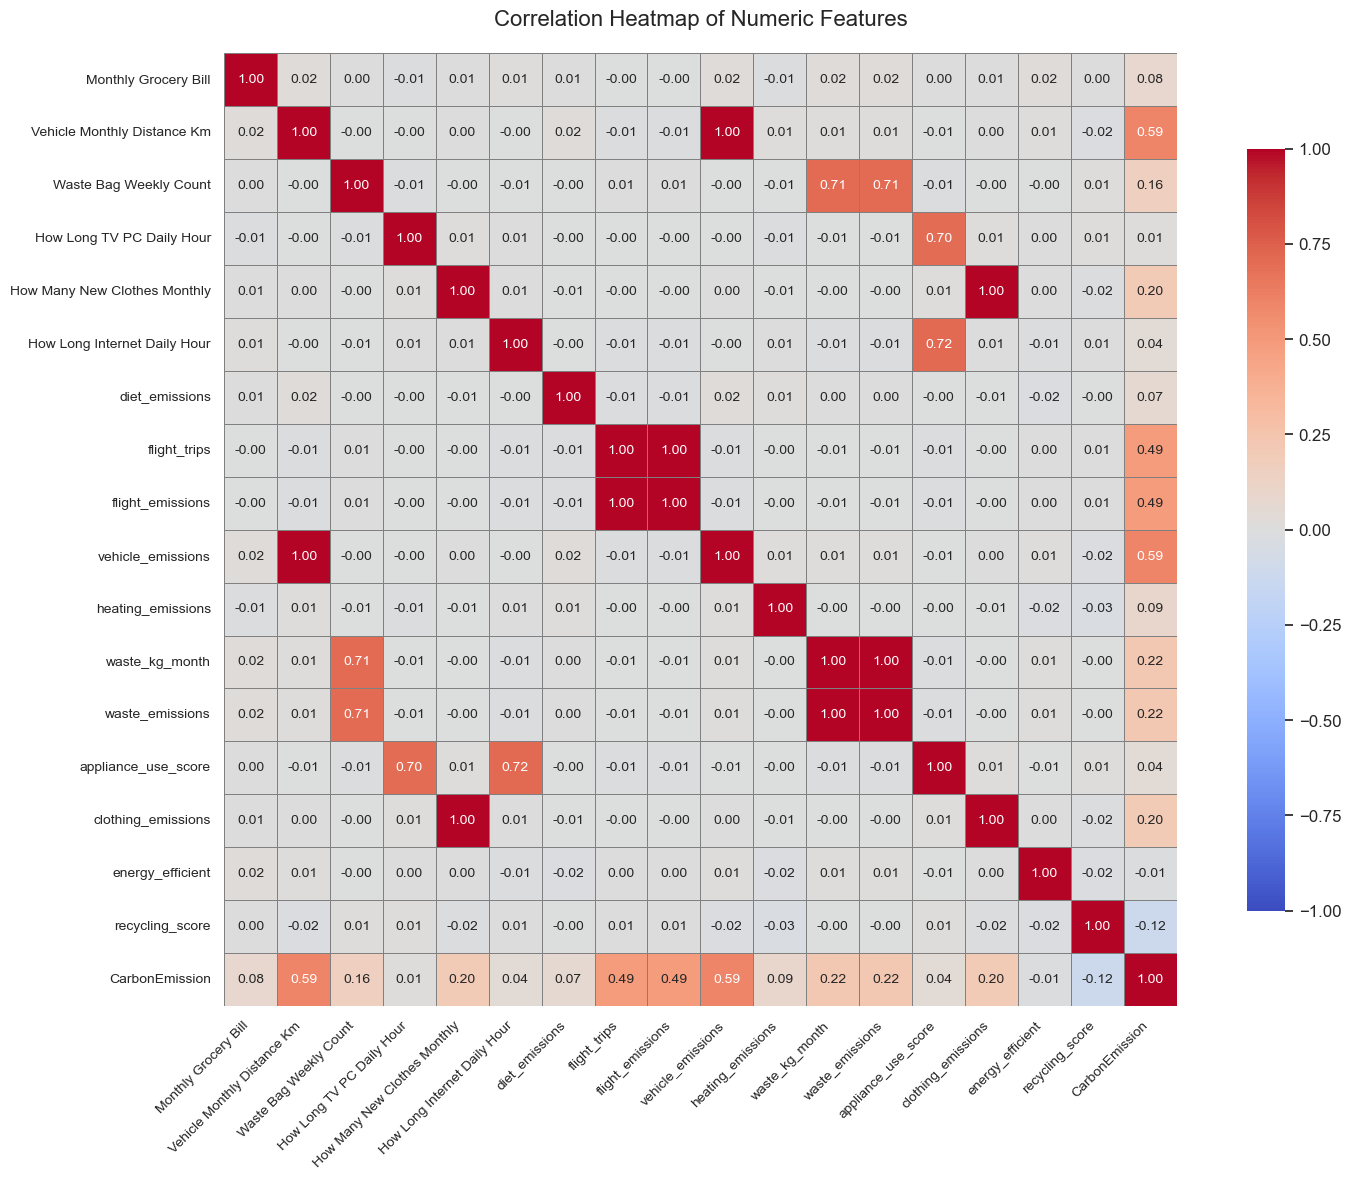

In [30]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(16, 12))
sns.heatmap(corr, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            linewidths=0.5, 
            linecolor='gray',
            annot_kws={"size": 10},
            cbar_kws={"shrink": 0.8},
            square=True,
            vmin=-1, vmax=1)  # ✅ Ensures 0 is the neutral midpoint

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.title("Correlation Heatmap of Numeric Features", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

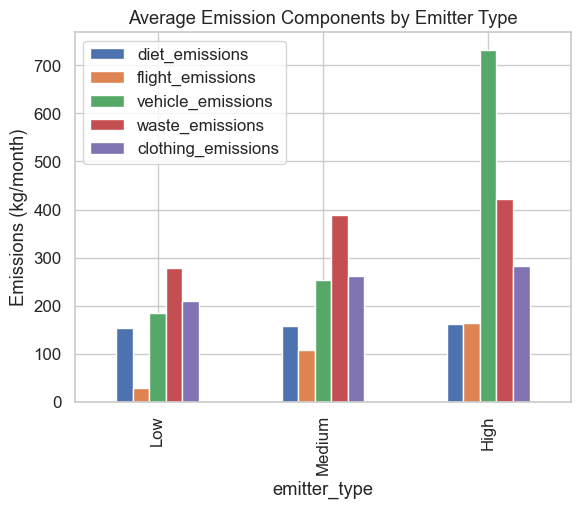

In [31]:
df['emitter_type'] = pd.qcut(df['CarbonEmission'], q=3, labels=['Low', 'Medium', 'High'])

df.groupby('emitter_type')[['diet_emissions', 'flight_emissions', 'vehicle_emissions',
                            'waste_emissions', 'clothing_emissions']].mean().plot(kind='bar')
plt.title("Average Emission Components by Emitter Type")
plt.ylabel("Emissions (kg/month)")
plt.show()

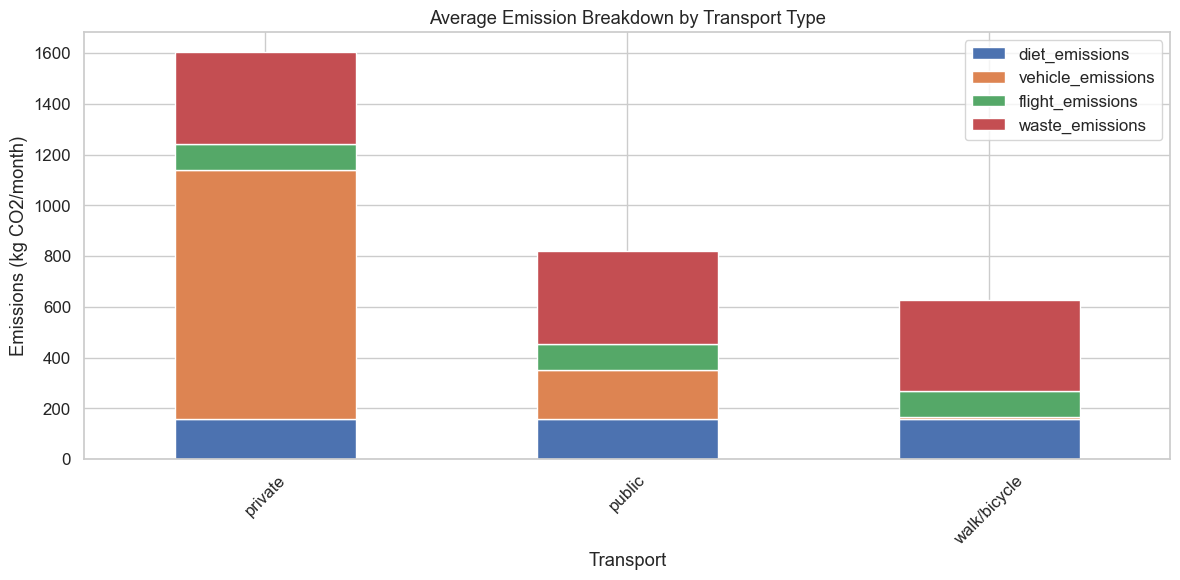

In [32]:
grouped = df.groupby('Transport')[['diet_emissions', 'vehicle_emissions', 'flight_emissions', 'waste_emissions']].mean()
grouped.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Average Emission Breakdown by Transport Type")
plt.ylabel("Emissions (kg CO2/month)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Carbon Emissions vs Fast Fashion Consumption')

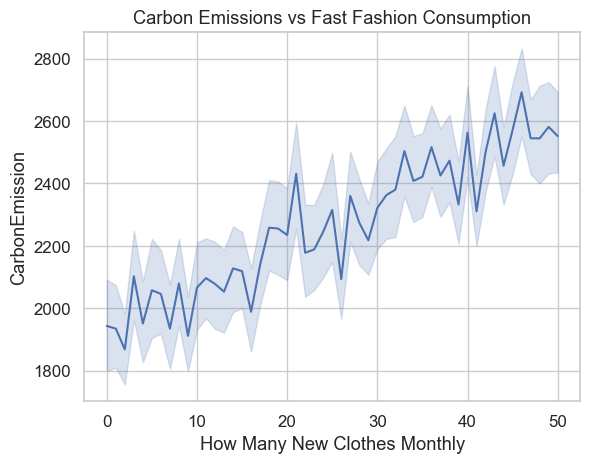

In [33]:
sns.lineplot(x='How Many New Clothes Monthly', y='CarbonEmission', data=df)
plt.title("Carbon Emissions vs Fast Fashion Consumption")

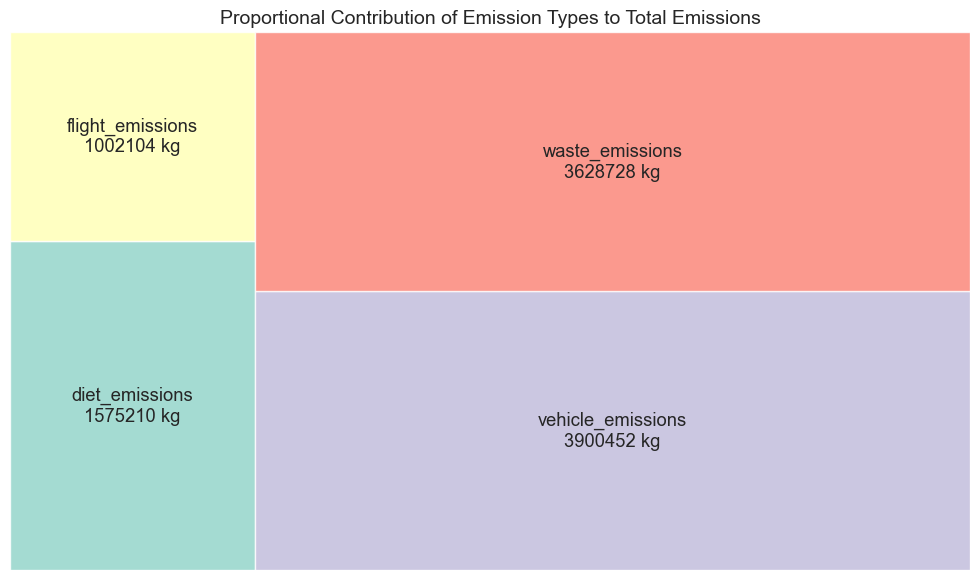

In [34]:
!pip install squarify
import matplotlib.pyplot as plt
import squarify

# Total emissions by type
emission_totals = df[['diet_emissions', 'flight_emissions', 'vehicle_emissions', 'waste_emissions']].sum()
labels = [f"{col}\n{int(val)} kg" for col, val in emission_totals.items()]

# Plot
plt.figure(figsize=(10, 6))
squarify.plot(sizes=emission_totals.values, label=labels, alpha=0.8, color=sns.color_palette("Set3"))
plt.title("Proportional Contribution of Emission Types to Total Emissions", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

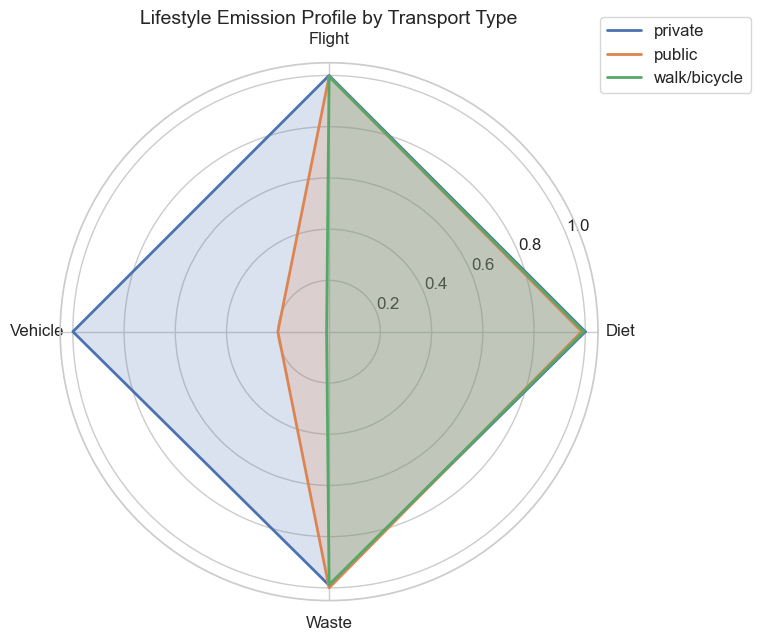

In [35]:
features = ['diet_emissions', 'flight_emissions', 'vehicle_emissions', 'waste_emissions']
labels = ['Diet', 'Flight', 'Vehicle', 'Waste']

grouped = df.groupby('Transport')[features].mean()

categories = ['private', 'public', 'walk/bicycle']
data = grouped.loc[categories].values

data_max = data.max(axis=0)
data = data / data_max

num_vars = len(features)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 


plt.figure(figsize=(8, 8))
for i, category in enumerate(categories):
    values = data[i].tolist()
    values += values[:1] 
    plt.polar(angles, values, label=category, linewidth=2)
    plt.fill(angles, values, alpha=0.2)

plt.xticks(angles[:-1], labels)
plt.title('Lifestyle Emission Profile by Transport Type', size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

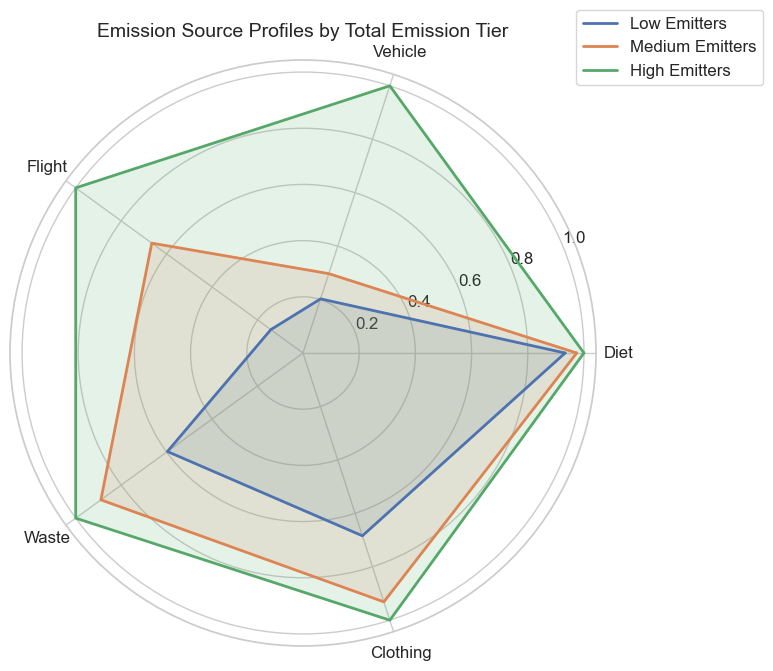

In [36]:
df['Emission_Tier'] = pd.qcut(df['CarbonEmission'], q=[0, 0.25, 0.75, 1.0], labels=['Low', 'Medium', 'High'])

features = ['diet_emissions', 'vehicle_emissions', 'flight_emissions', 'waste_emissions', 'clothing_emissions']
labels = ['Diet', 'Vehicle', 'Flight', 'Waste', 'Clothing']

grouped = df.groupby('Emission_Tier')[features].mean().loc[['Low', 'Medium', 'High']]

data = grouped.values
data_max = data.max(axis=0)
data = data / data_max

num_vars = len(features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8, 8))
for i, tier in enumerate(grouped.index):
    values = data[i].tolist()
    values += values[:1]
    plt.polar(angles, values, label=f"{tier} Emitters", linewidth=2)
    plt.fill(angles, values, alpha=0.15)

plt.xticks(angles[:-1], labels)
plt.title('Emission Source Profiles by Total Emission Tier', size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

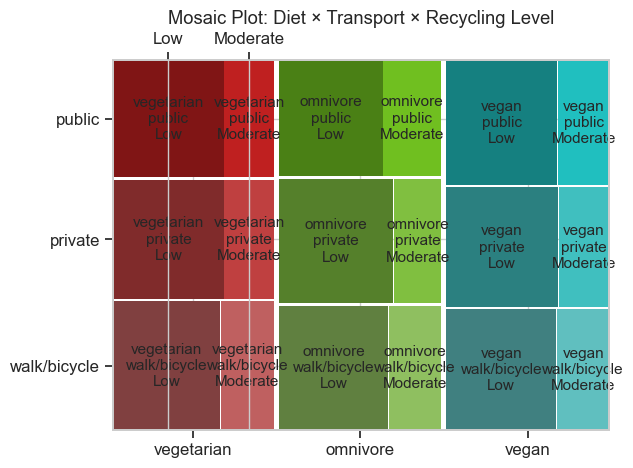

In [37]:
df['Diet'] = df['Diet'].str.lower()
df['Transport'] = df['Transport'].str.lower()
df['recycling_score'] = df['Recycling'].apply(lambda x: len(eval(x)) if pd.notnull(x) else 0)
df['Recycling_Level'] = pd.cut(df['recycling_score'], bins=[-1, 2, 4, 10], labels=['Low', 'Moderate', 'High'])

filtered = df.dropna(subset=['Diet', 'Transport', 'Recycling_Level'])
filtered = filtered[filtered['Diet'].isin(['vegan', 'vegetarian', 'omnivore', 'meat-heavy'])]
filtered = filtered[filtered['Transport'].isin(['private', 'public', 'walk/bicycle'])]

counts = filtered.groupby(['Diet', 'Transport', 'Recycling_Level']).size()
mosaic_data = {(d, t, r): counts.get((d, t, r), 0)
               for d in filtered['Diet'].unique()
               for t in filtered['Transport'].unique()
               for r in filtered['Recycling_Level'].unique()}

plt.figure(figsize=(12, 8))
mosaic(mosaic_data, title="Mosaic Plot: Diet × Transport × Recycling Level", gap=0.01)
plt.show()

In [38]:
from scipy.stats import mannwhitneyu
from itertools import combinations
import pandas as pd

def mannwhitney_for_all_groups(df, target_col='CarbonEmission', significance_level=0.05):
    categorical_cols = df.select_dtypes(include='object').columns.tolist()

    results = []

    for col in categorical_cols:
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) < 2 or len(unique_vals) > 10:
            continue  

        for a, b in combinations(unique_vals, 2):
            group_a = df[df[col] == a][target_col]
            group_b = df[df[col] == b][target_col]

            if len(group_a) < 10 or len(group_b) < 10:
                continue

            stat, p = mannwhitneyu(group_a, group_b, alternative='two-sided')
            results.append({
                'Variable': col,
                'Group A': a,
                'Group B': b,
                'U-Statistic': stat,
                'P-Value': p,
                'Significant': p < significance_level
            })

    return pd.DataFrame(results)

mw_results = mannwhitney_for_all_groups(df)

significant_results = mw_results[mw_results['Significant'] == True].sort_values(by='P-Value')

print("Top Significant Mann–Whitney U Test Results (p < 0.05):")
print(significant_results.head(10).to_string(index=False))

Top Significant Mann–Whitney U Test Results (p < 0.05):
                     Variable      Group A         Group B  U-Statistic       P-Value  Significant
                    Transport walk/bicycle         private    2477968.0  0.000000e+00         True
Frequency of Traveling by Air        never very frequently     699883.0  0.000000e+00         True
Frequency of Traveling by Air       rarely very frequently     980807.5  0.000000e+00         True
                    Transport       public         private    2615512.0 5.078568e-287         True
Frequency of Traveling by Air   frequently           never    4696622.5 3.465415e-216         True
Frequency of Traveling by Air   frequently very frequently    1615840.5 4.304828e-205         True
Frequency of Traveling by Air   frequently          rarely    4243425.5 3.256948e-106         True
                    Body Type        obese     underweight    4130679.5  1.929351e-76         True
        Heating Energy Source         coal     electr

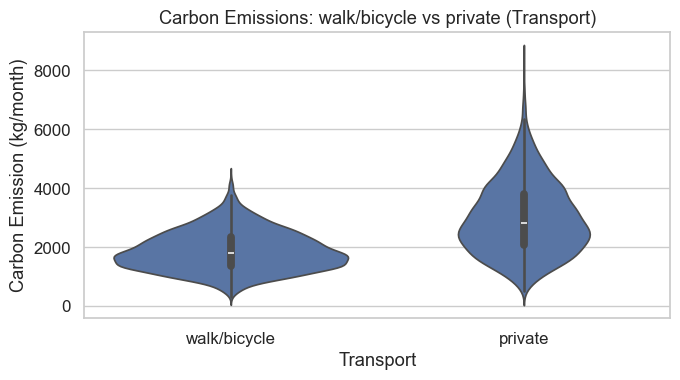

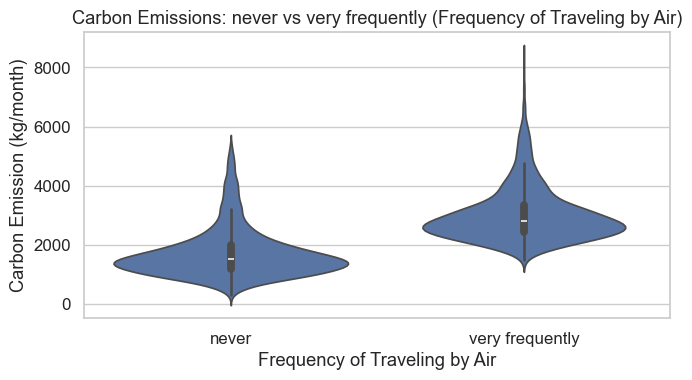

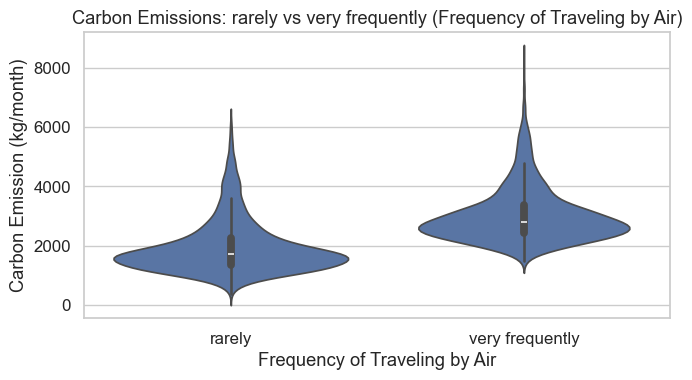

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

top_3 = significant_results.head(3)

for idx, row in top_3.iterrows():
    var = row['Variable']
    group_a = row['Group A']
    group_b = row['Group B']

    df_plot = df[df[var].isin([group_a, group_b])]

    plt.figure(figsize=(7, 4))
    sns.violinplot(x=var, y='CarbonEmission', data=df_plot, order=[group_a, group_b])
    plt.title(f"Carbon Emissions: {group_a} vs {group_b} ({var})")
    plt.ylabel("Carbon Emission (kg/month)")
    plt.xlabel(var)
    plt.tight_layout()

## Regression Modeling

Before going with modelling, lets drop the columns which we created just to visualize some information. Having them will just complicate the modeling process with data leakage problems as they are essentially nothing but derivates of other features.

In [42]:
df.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,...,waste_kg_month,waste_emissions,appliance_use_score,clothing_emissions,energy_efficient,recycling_score,CarbonEmission,emitter_type,Emission_Tier,Recycling_Level
0,overweight,female,pescatarian,daily,coal,public,often,230,frequently,210,...,240,432.0,8,260,0.0,1,2238,Medium,Medium,Low
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,often,114,rarely,9,...,240,432.0,14,380,0.0,1,1892,Medium,Medium,Low
2,overweight,male,omnivore,more frequently,wood,private,never,138,never,2472,...,20,36.0,20,470,0.5,1,2595,High,Medium,Low
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,sometimes,157,rarely,74,...,120,216.0,27,50,0.5,4,1074,Low,Low,Moderate
4,obese,female,vegetarian,daily,coal,private,often,266,very frequently,8457,...,60,108.0,9,50,1.0,1,4743,High,High,Low


In [43]:
columns_to_drop = [
    'diet_emissions', 'flight_emissions', 'vehicle_emissions',
    'heating_emissions', 'waste_kg_month', 'waste_emissions','emitter_type', 'Emission_Tier', 'Recycling_Level',
    'clothing_emissions', 'appliance_use_score', 'energy_efficient', 'recycling_score','flight_trips'
]

df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

In [44]:
df_copy = pd.read_csv('new_emissions.csv')
df_copy = df_copy.drop(columns=[col for col in columns_to_drop if col in df_copy.columns])

In [45]:
df.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Body Type                      10000 non-null  object
 1   Sex                            10000 non-null  object
 2   Diet                           10000 non-null  object
 3   How Often Shower               10000 non-null  object
 4   Heating Energy Source          10000 non-null  object
 5   Transport                      10000 non-null  object
 6   Social Activity                10000 non-null  object
 7   Monthly Grocery Bill           10000 non-null  int64 
 8   Frequency of Traveling by Air  10000 non-null  object
 9   Vehicle Monthly Distance Km    10000 non-null  int64 
 10  Waste Bag Size                 10000 non-null  object
 11  Waste Bag Weekly Count         10000 non-null  int64 
 12  How Long TV PC Daily Hour      10000 non-null  int64 
 13  Ho

In [47]:
categorical_columns = df.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()

for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [48]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [50]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

### Different Regression Models with hyperparameters

In [52]:
models = {
    'Ridge': Ridge(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(oob_score=True, random_state=0),
    'XGBRegressor': XGBRegressor(random_state=0, verbosity=0),
    'CatBoostRegressor' : CatBoostRegressor(verbose=100, random_state=42)
}

param_grids = {
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0]
    },
    'DecisionTreeRegressor': {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVR': {
        'C': [1, 10],
        'epsilon': [0.01, 0.1],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    },
    'RandomForestRegressor': {
        'n_estimators': [50, 100],
        'max_depth': [8, 12],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 3],
        'max_features': ['sqrt']
    },
    'XGBRegressor': {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1, 0.3],
        'max_depth': [3, 6, 9],
        'subsample': [1.0, 0.8, 0.5],
        'colsample_bytree': [0.8,1.0,1.2]
    },
    'CatBoostRegressor' : {
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'iterations': [100, 200, 500]
}
}


### GridSearch for all the above models and its hyperparameters

In [53]:
best_models = {}
for name in models:
    print(f"\nRunning GridSearchCV for {name}...")
    grid = GridSearchCV(models[name], param_grids[name], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    
    best_rmse = (-grid.best_score_) ** 0.5
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best RMSE: {round(best_rmse, 4)}")


Running GridSearchCV for Ridge...
Best Parameters: {'alpha': 10.0}
Best RMSE: 692.7813

Running GridSearchCV for DecisionTreeRegressor...
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best RMSE: 627.8932

Running GridSearchCV for SVR...
Best Parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Best RMSE: 787.8949

Running GridSearchCV for RandomForestRegressor...
Best Parameters: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: 533.6153

Running GridSearchCV for XGBRegressor...
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best RMSE: 465.5053

Running GridSearchCV for CatBoostRegressor...
0:	learn: 987.5703406	total: 57.5ms	remaining: 11.5s
100:	learn: 446.3019181	total: 133ms	remaining: 130ms
199:	learn: 387.2428546	total: 203ms	remaining: 0us
Best Parameters: {'depth': 6, 'iterations': 

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\nEvaluating best models on test set...\n")

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R²  : {r2:.4f}")
    print("-" * 40)


Evaluating best models on test set...

Ridge Performance:
  RMSE: 683.6310
  MAE : 541.0233
  R²  : 0.5505
----------------------------------------
DecisionTreeRegressor Performance:
  RMSE: 616.1371
  MAE : 448.1329
  R²  : 0.6349
----------------------------------------
SVR Performance:
  RMSE: 739.1648
  MAE : 551.2270
  R²  : 0.4745
----------------------------------------
RandomForestRegressor Performance:
  RMSE: 511.2302
  MAE : 338.6591
  R²  : 0.7486
----------------------------------------
XGBRegressor Performance:
  RMSE: 450.1356
  MAE : 256.0065
  R²  : 0.8051
----------------------------------------
CatBoostRegressor Performance:
  RMSE: 443.5909
  MAE : 247.3343
  R²  : 0.8107
----------------------------------------


In [55]:
results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    results.append({
        'Model': name,
        'RMSE': mean_squared_error(y_test, y_pred, squared=False),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MAE')
results_df.reset_index(drop=True, inplace=True)
results_df.head(6)

,Model,RMSE,MAE,R2
0,CatBoostRegressor,443.590865,247.334255,0.810742
1,XGBRegressor,450.135610,256.006503,0.805116
2,RandomForestRegressor,511.230245,338.659094,0.748625
3,DecisionTreeRegressor,616.137136,448.132915,0.634874
4,Ridge,683.631029,541.023336,0.550498
5,SVR,739.164834,551.227031,0.474502


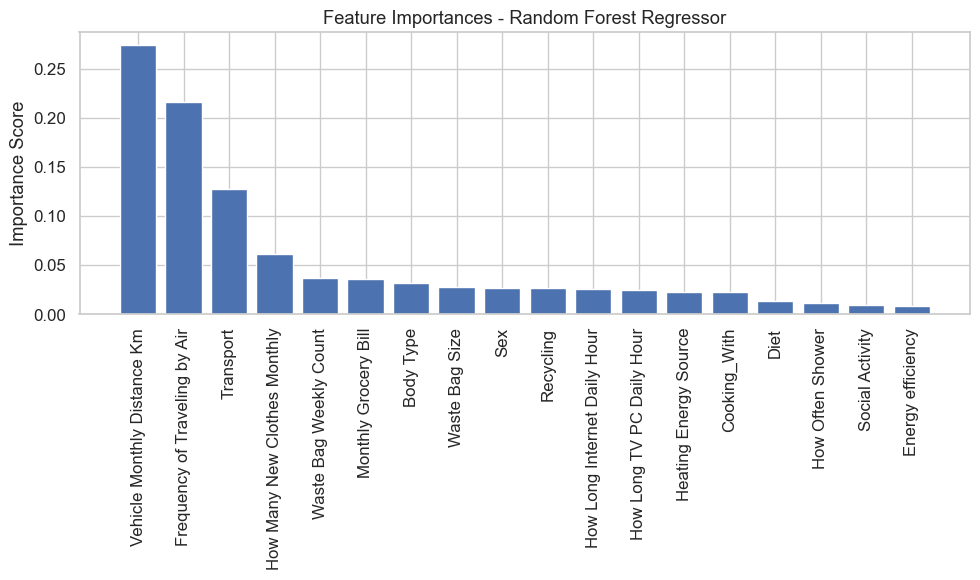

In [56]:
rf_model = best_models['RandomForestRegressor']

feature_names = df.columns[:-1]
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.ylabel("Importance Score")
plt.title("Feature Importances - Random Forest Regressor")
plt.tight_layout()
plt.show()

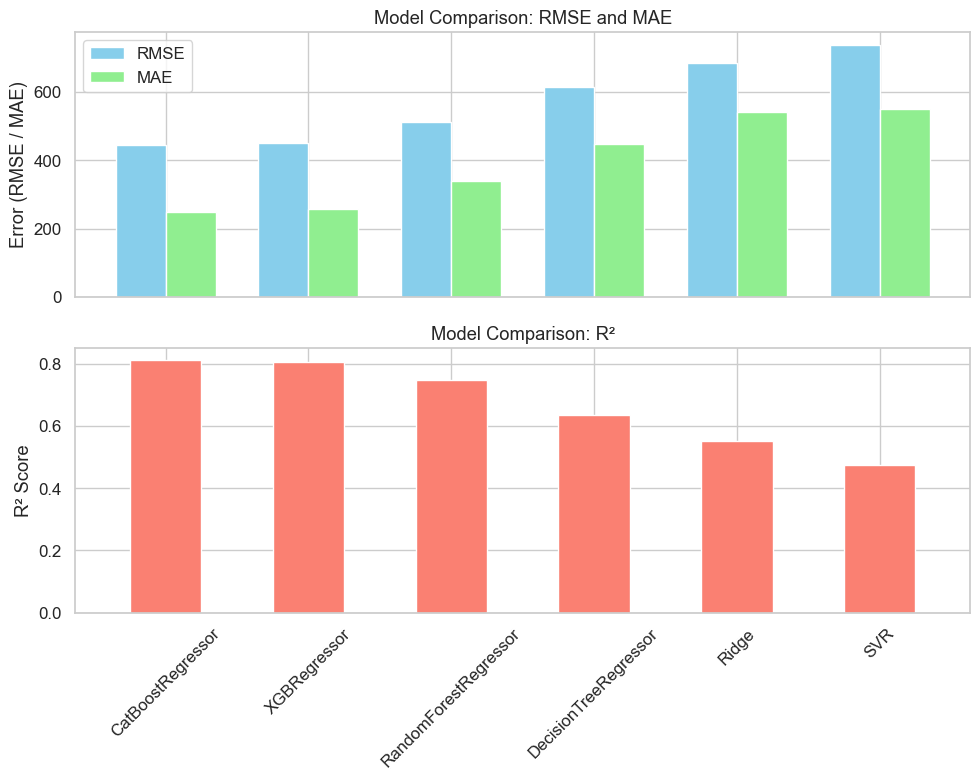

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

x = np.arange(len(results_df['Model']))
width = 0.35

# --- Top Plot: RMSE & MAE ---
ax1.bar(x - width/2, results_df['RMSE'], width, label='RMSE', color='skyblue')
ax1.bar(x + width/2, results_df['MAE'], width, label='MAE', color='lightgreen')
ax1.set_ylabel("Error (RMSE / MAE)")
ax1.set_title("Model Comparison: RMSE and MAE")
ax1.legend()
ax1.grid(True, axis='y')

# --- Bottom Plot: R² ---
ax2.bar(x, results_df['R2'], width=0.5, color='salmon')
ax2.set_ylabel("R² Score")
ax2.set_title("Model Comparison: R²")
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Model'], rotation=45)
ax2.grid(True, axis='y')

plt.tight_layout()
plt.show()

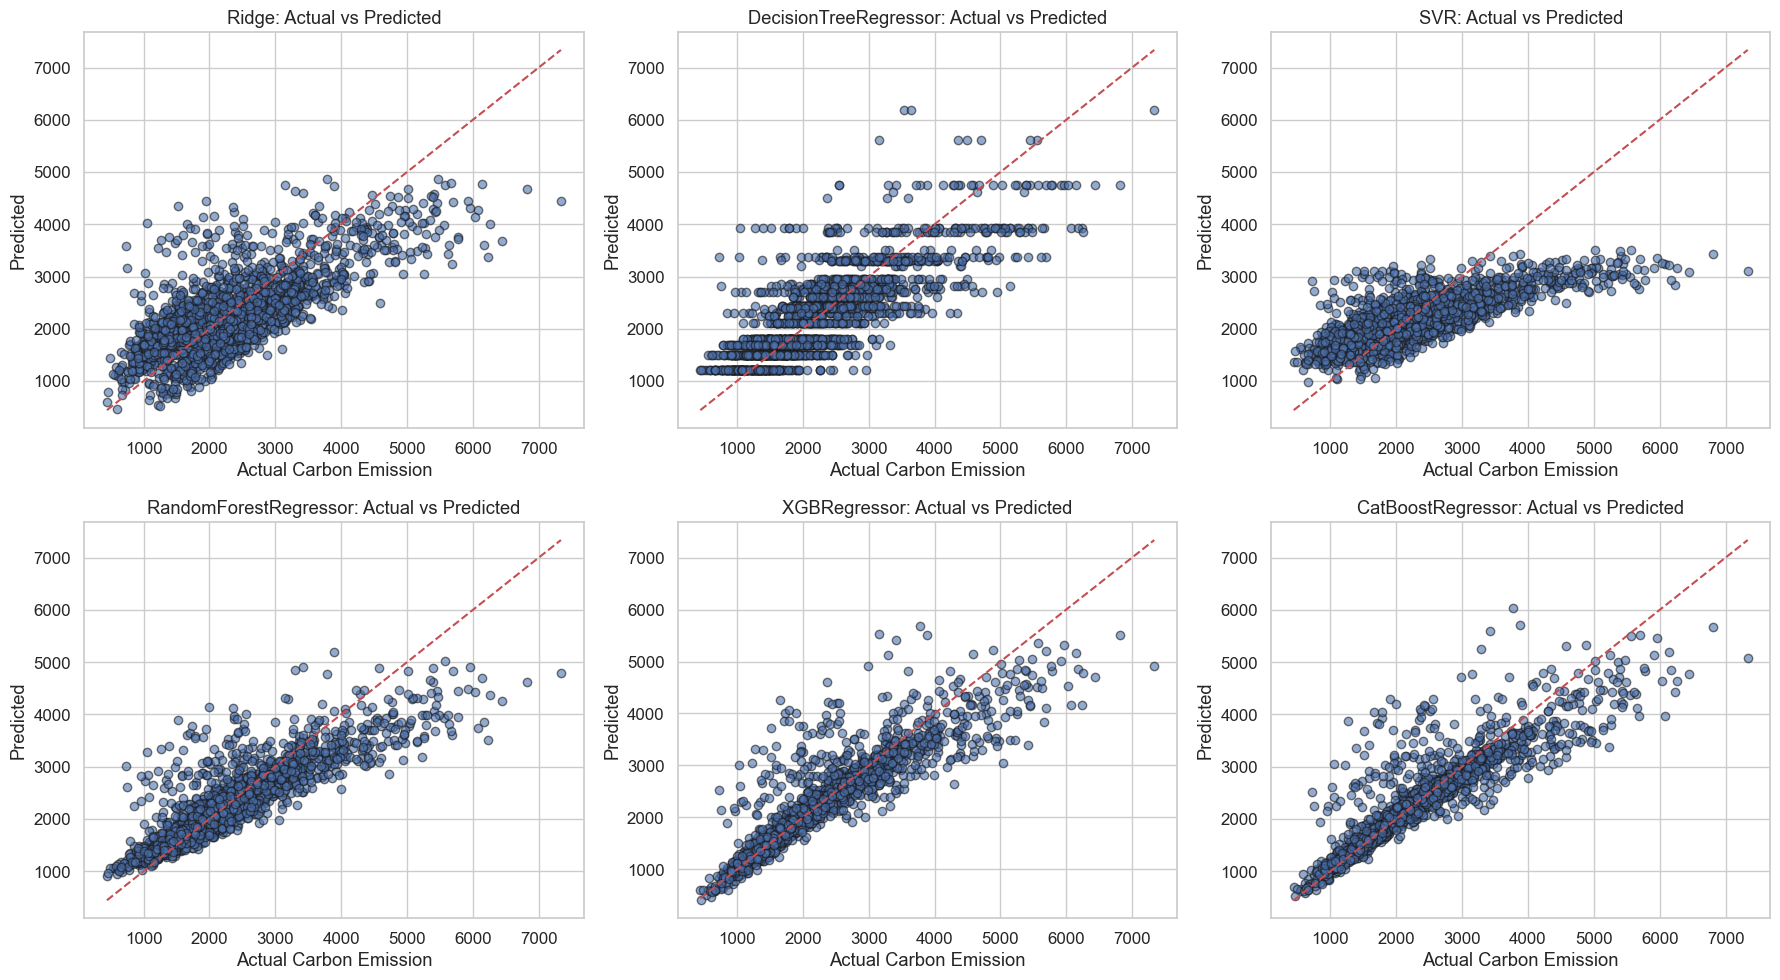

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) 
axes = axes.flatten() 

for i, (name, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test)

    # Scatter plot
    axes[i].scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[i].set_title(f'{name}: Actual vs Predicted')
    axes[i].set_xlabel("Actual Carbon Emission")
    axes[i].set_ylabel("Predicted")
    axes[i].grid(True)



plt.tight_layout()
plt.show()

### Deep Learning - A Simple ANN

In [59]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [60]:
model = Sequential()

model.add(Dense(256, activation='relu',input_dim=18))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='linear'))

In [61]:
model.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mean_absolute_error'])


In [62]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1012.1748 - mean_absolute_error: 1012.1748
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 369.4889 - mean_absolute_error: 369.4889
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 322.2029 - mean_absolute_error: 322.2029
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 301.0952 - mean_absolute_error: 301.0952
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 294.2828 - mean_absolute_error: 294.2828
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 277.5165 - mean_absolute_error: 277.5165
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 273.5128 - mean_absolute_error: 273.5128
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 250.0274 - mean_absolute_error: 250.0274
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 257.2764 - mean_absolute_error: 257.2764
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 244.8143 - mean_absolute_err

In [63]:
y_ann = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step


In [64]:
mean_absolute_error(y_test, y_ann)

268.5879366607666

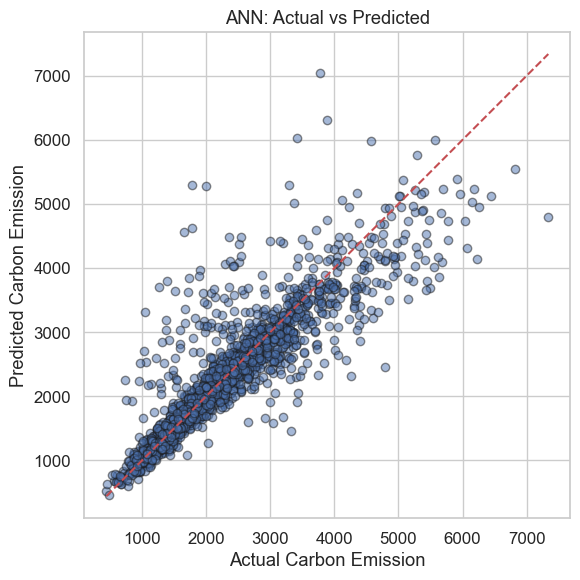

In [65]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_ann, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Carbon Emission")
plt.ylabel("Predicted Carbon Emission")
plt.title("ANN: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### Saving Model and Scalar for Streamlit

In [66]:
import joblib

joblib.dump(best_models['CatBoostRegressor'], 'catboost_emission_model.pkl')

['catboost_emission_model.pkl']

In [67]:
joblib.dump(sc, "scaler.pkl")

['scaler.pkl']

### Code for app.py ( DONT RUN IT HERE!)

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib

model = joblib.load("catboost_emission_model.pkl")

st.title("🌿 Carbon Emission Estimator")
st.markdown("Usable AI - Project Demo")
st.markdown("Surya Teja mothukuri - smothuk@iu.edu")

st.markdown("Fill in your lifestyle details to estimate your monthly carbon emissions:")


col1, col2, col3 = st.columns(3)

with col1:
    body_type = st.selectbox("Body Type", ["Slim", "Average", "Overweight"])
    sex = st.selectbox("Sex", ["Male", "Female"])
    diet = st.selectbox("Diet", ["Omnivore", "Vegetarian", "Vegan"])
    shower_freq = st.slider("Shower/week", 0, 21, 7)
    heating_source = st.selectbox("Heating Energy", ["Gas", "Electric", "Wood", "None"])
    transport = st.selectbox("Transport", ["Car", "Public Transport", "Bike", "Walk"])

with col2:
    social_activity = st.slider("Social Activity/week", 0, 14, 3)
    grocery_bill = st.number_input("Monthly Grocery ($)", 100, 2000, 400)
    flight_freq = st.slider("Flight Trips/year", 0, 20, 2)
    vehicle_distance = st.slider("Monthly Vehicle Km", 0, 5000, 500)
    waste_bag_size = st.selectbox("Waste Bag Size", ["Small", "Medium", "Large"])
    waste_bag_count = st.slider("Waste Bags/week", 0, 10, 2)

with col3:
    tv_pc_hours = st.slider("Daily TV/PC Hours", 0, 24, 4)
    clothes_count = st.slider("Clothes/month", 0, 20, 2)
    internet_hours = st.slider("Internet Hours/day", 0, 24, 5)
    energy_eff = st.selectbox("Energy Efficient?", ["Yes", "No"])
    recycling = st.selectbox("Recycling Level", ["Never", "Sometimes", "Always"])
    cooking_with = st.selectbox("Cooking Fuel", ["Gas", "Electric", "Wood"])

input_data = pd.DataFrame([[
    {"Slim": 0, "Average": 1, "Overweight": 2}[body_type],
    0 if sex == "Male" else 1,
    {"Omnivore": 0, "Vegetarian": 1, "Vegan": 2}[diet],
    shower_freq,
    {"Gas": 0, "Electric": 1, "Wood": 2, "None": 3}[heating_source],
    {"Car": 0, "Public Transport": 1, "Bike": 2, "Walk": 3}[transport],
    social_activity,
    grocery_bill,
    flight_freq,
    vehicle_distance,
    {"Small": 0, "Medium": 1, "Large": 2}[waste_bag_size],
    waste_bag_count,
    tv_pc_hours,
    clothes_count,
    internet_hours,
    1 if energy_eff == "Yes" else 0,
    {"Never": 0, "Sometimes": 1, "Always": 2}[recycling],
    {"Gas": 0, "Electric": 1, "Wood": 2}[cooking_with]
]], columns=[
    'Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
    'Transport', 'Social Activity', 'Monthly Grocery Bill',
    'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
    'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour',
    'How Many New Clothes Monthly', 'How Long Internet Daily Hour',
    'Energy efficiency', 'Recycling', 'Cooking_With'
])


if st.button("Estimate Emission"):
    scaler = joblib.load("scaler.pkl")
    input_data_scaled = scaler.transform(input_data)
    prediction = model.predict(input_data_scaled)[0]
    st.success(f"🌍 Estimated Monthly Carbon Emission: {prediction:.2f} kg CO₂")